#  Dynamic Message Passing(DMP) for IC model

When the recovery rate of the SIR model is 100%，the discrete SIR model will degenerate to Independent Cascade model which is the bases of information diffusion modeling. According to `Inferring the origin of an epidemic with a dynamic message-passing algorithm `, we can simplify their DMP and get the iterative formula for IC model.

**Initialization：**

$\theta^{k\rightarrow i}=0$

$\phi^{k\rightarrow i}= \delta [q_{k}(0), I]$

**Iteration：**

$P_{S}^{k\rightarrow i}(t+1) = P_{S}^{k}(0)\prod_{j\in\alpha_k \: j\neq i} \theta^{j\rightarrow k}(t+1)$

$\theta^{k\rightarrow i}(t+1) = \theta^{k\rightarrow i}(t) - w_{ki}\phi^{k\rightarrow i}(t)$

$\phi^{k\rightarrow i}(t) = P_S^{k\rightarrow i}(t-1) - P_{S}^{k\rightarrow i }(t)$


**The probability of being activated at time t+1：**

$P_{S}^{i}(t+1) = P_{S}^{i}(0)\prod_{j\in\alpha_k} \theta^{j\rightarrow k}(t+1)$

$P_{active}^{i}(t+1) = 1 - P_{S}^{i}(t+1)$

In [1]:
import networkx as nx
import numpy    as np
import scipy
import matplotlib.pyplot as plt
from functools import reduce
from copy import deepcopy

In [2]:
def update(G):
    """
    One-step update function of DMP.
    INPUT:
        G: nx.DiGraph(). each edge of G has four attributes, w, theta, phi and P. 
        each node has attribute P0 which indicates whether the node is a seed node.
    Return:
        G: nx.DiGraph(). edges' informathion updated.
    """
    edges = list(G.edges)
    # Step1:updat theta
    for edge in edges:
        G.edges[edge]["theta"] -= G.edges[edge]["w"]*G.edges[edge]["phi"]
        
    # Step2:update P
    for edge in edges:
        in_neighbors = [i[0] for i in list(G.in_edges(edge[0]))]
        if edge[1] in in_neighbors:
            in_neighbors.remove(edge[1])

        if len(in_neighbors)>0:
            Prod = reduce(lambda x,y: x*y, [G.edges[node, edge[0]]["theta"] for node in in_neighbors])
        else:
            Prod = 1

        G.edges[edge]["P"].insert(0, G.nodes[edge[0]]["P0"] * Prod)
        if len(G.edges[edge]["P"]) > 2:
            G.edges[edge]["P"].pop()
            
    # Step3:update phi
    for edge in edges:
        Ps = G.edges[edge]["P"]
        assert len(Ps) == 2
        G.edges[edge]["phi"] = Ps[1] - Ps[0]
        
    return G

In [3]:
def output(G):
    """
    Calculate nodes' probability of being active.
    Input:
        G: nx.DiGraph(). each edge of G has four attributes, w, theta, phi and P. 
        each node has attribute P0 which indicates whether the node is a seed node.
    Return: 
        node_Pi_dict: dict. key/value=node_id/prob.
    
    """
    nodes = list(G.nodes)
    node_Pi_dict = {}
    for node in nodes:
        in_neighbors = [i[0] for i in list(G.in_edges(node))]
        if len(in_neighbors)==0:
            node_Pi_dict[node] = 1 - G.nodes[node]["P0"]
        else:
            Prod = reduce(lambda x,y: x*y, [G.edges[nei, node]["theta"] for nei in in_neighbors])
            node_Pi_dict[node] = 1 - G.nodes[node]["P0"] * Prod
            
    return node_Pi_dict

# Test

In [4]:
G = nx.random_graphs.erdos_renyi_graph(n=100, p=0.1, directed=True)
edges = list(G.edges())
edge_w = [np.random.uniform(0,0.3) for e in edges]
seeds = np.random.choice(len(G), size = 5, replace=False)

## G's nodes and edges initializing
for node in list(G.nodes):
    if node in seeds:
        G.nodes[node]["P0"] = 0
    else:
        G.nodes[node]["P0"] = 1

for i, edge in enumerate(edges):
    G.edges[edge]["w"] = edge_w[i]
    G.edges[edge]["theta"] = 1
    G.edges[edge]["phi"] = 1 - G.nodes[edge[0]]["P0"]
    G.edges[edge]["P"] = [G.nodes[edge[0]]["P0"]]

In [5]:
log = []
G_copy = deepcopy(G)
log.append(output(G_copy))

while True:
    G_copy = update(G_copy)
    log.append(output(G_copy))
    # keep updating untill no more newly actived nodes
    if abs(sum(list(log[-1].values()))-sum(list(log[-2].values()))) < 0.01:
        break

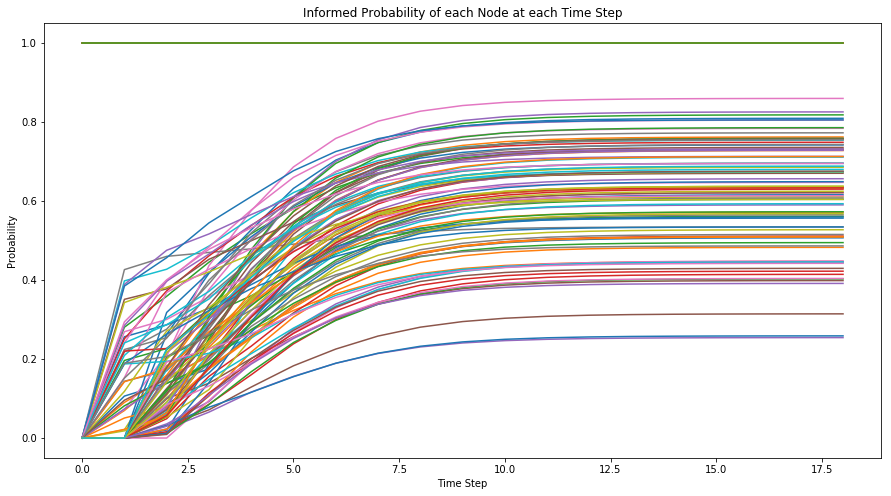

In [6]:
v = []
for i in range(len(log)):
    v.append(list(log[i].values()))
    
v = np.array(v).T
plt.figure(figsize=(15,8))
plt.plot(v.T[:,:])
plt.title("Informed Probability of each Node at each Time Step")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.show()

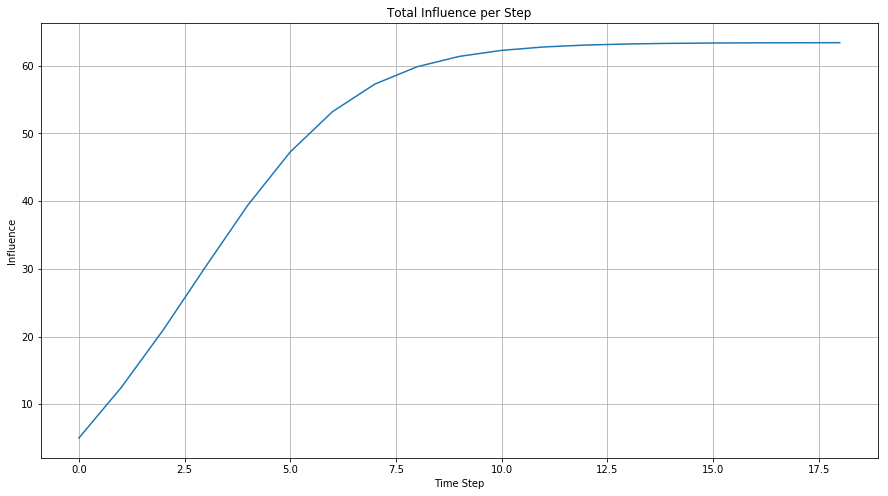

In [7]:
plt.figure(figsize=(15,8))
plt.plot(np.sum(v, axis=0))
plt.grid(True)
plt.title("Total Influence per Step")
plt.xlabel("Time Step")
plt.ylabel("Influence")
plt.show()